### Thresholds for HC codes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, List, Dict, Any, Set, FrozenSet, Iterable, Tuple
import math
import random
import networkx as nx
import sympy as sym

import os
import galois

from HC_ZN_functions import *

First lets restrict to $q=2$ and compare with MWPM

In [65]:
from pymatching import Matching

In [66]:
N_list = [2,4]
p_list = [.001,.003, .005, .008]

runs = 2*10**4

threshold_matching = {}

In [2]:
commutator = lambda a,b: (a[0] @ b[0] - a[1]@b[1]) % 2

In [68]:
for N in N_list:
    code1 = HC_code(N,N,2)
    code1.make_tanner_graph()
    code1.make_H()
    code1.logicals()
    GF = galois.GF(code1.q)

    threshold_matching[N] = []
    for p in p_list:
        matching = Matching(code1.H, weights=np.log((1-p)/p))

        counter = 0
        for _ in range(runs):   
            code1.make_error(p, meas=False)

            predicted_error = matching.decode((code1.H @ code1.E) % 2)
            code1.final_pauli(code1.E+predicted_error)

            if commutator(code1.L1v, code1.error_XZ) != 0:
                counter +=1
        
        threshold_matching[N].append(1-counter/runs)
    print(threshold_matching[N])

[0.9878, 0.96355, 0.9407, 0.9092]
[0.9337, 0.8257, 0.7408, 0.6573]


## Weird we don't see crossover?

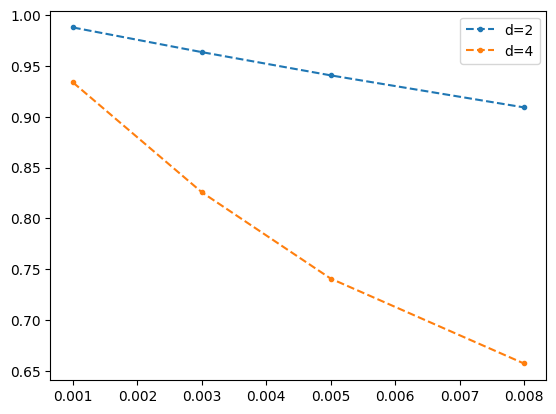

In [69]:
for N in N_list:
    plt.plot(p_list, threshold_matching[N], '.--', label = f'd={N}')
plt.legend()

### Next lets look at cluster decoder for qutrits

In [10]:
from joblib import Parallel, delayed

import time 

In [3]:
def sim_code(code,p):
    commutator = lambda a,b: (a[0] @ b[0] - a[1]@b[1]) % code.q
    
    counter = 0
    code.make_error(p, meas=False)
    code.final_pauli(my_HC_decoder(code,code.E)[0])

    if commutator(code.L1v, code.error_XZ) != 0: # or commutator(code.L1h, code.error_XZ) !=0: 
        counter +=1

    return counter

In [4]:
q_list = [2,3,5,7]
N_list = [3,4]
p_list = [.01,.02,.04,.05,.06,.07]

runs = 2*10**3

In [5]:
threshold_list = {}

for q in q_list:
    for N in N_list:    
        code1 = HC_code(N,2,q)
        code1.make_tanner_graph()
        code1.make_H()
        code1.logicals()
        GF = galois.GF(code1.q)

        threshold_list[q,N] = []

        t0 = time.time()
        for p in p_list:
            sim_p = lambda : sim_code(code1, p)

            sim_array = np.array(Parallel(n_jobs=-1)(delayed(sim_p)() for n in list(range(runs))))

            threshold_list[q,N].append(1-sim_array.sum()/runs)

        print(f'threshhold {threshold_list[q,N]} for (q,d) = {(q,N)} took {(time.time()-t0)/60} mins')

threshhold [0.9795, 0.911, 0.737, 0.644, 0.5935, 0.5575] for (q,d) = (2, 3) took 1.955927069981893 mins
threshhold [0.997, 0.952, 0.737, 0.667, 0.5875, 0.518] for (q,d) = (2, 4) took 4.947868418693543 mins
threshhold [0.977, 0.9075, 0.667, 0.558, 0.49150000000000005, 0.399] for (q,d) = (3, 3) took 2.2934287667274473 mins
threshhold [0.994, 0.951, 0.704, 0.5695, 0.477, 0.39549999999999996] for (q,d) = (3, 4) took 9.222201232115427 mins
threshhold [0.9815, 0.8985, 0.6525000000000001, 0.5585, 0.4335, 0.359] for (q,d) = (5, 3) took 2.255964283148448 mins
threshhold [0.9905, 0.9525, 0.7, 0.523, 0.403, 0.32199999999999995] for (q,d) = (5, 4) took 26.00365341901779 mins
threshhold [0.975, 0.903, 0.6635, 0.5425, 0.44499999999999995, 0.3355] for (q,d) = (7, 3) took 2.9854918320973716 mins
threshhold [0.993, 0.949, 0.7090000000000001, 0.531, 0.391, 0.30000000000000004] for (q,d) = (7, 4) took 54.49014439980189 mins


Add a few more data points

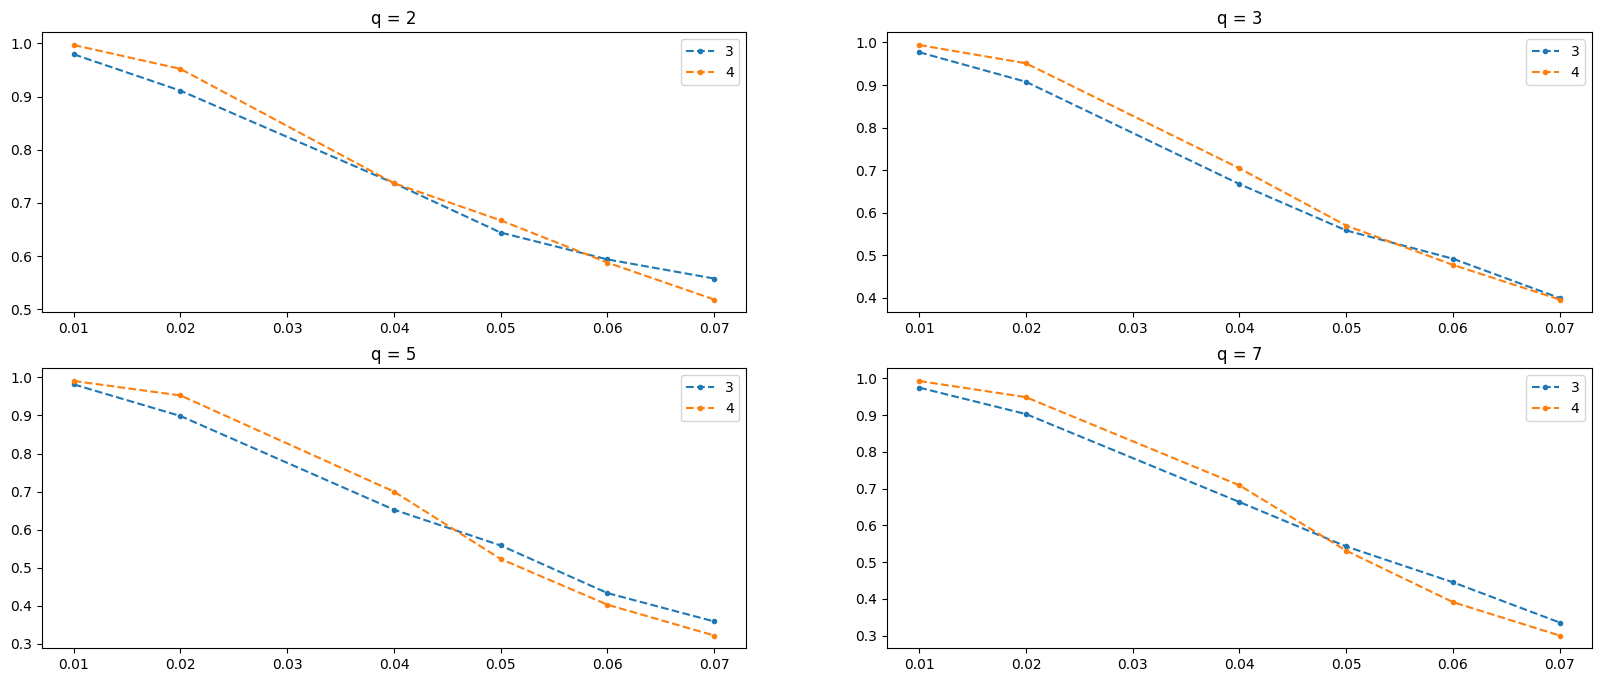

In [6]:
axs = {}

fig = plt.figure(figsize = (20,8))

for i, q in enumerate(q_list):
    axs[i+1] = fig.add_subplot(2,2,i+1)
    for N in N_list:
        axs[i+1].plot(p_list, threshold_list[q,N], '.--', label = f'{N}')
    
    axs[i+1].legend()
    axs[i+1].set_title(f'q = {q}')

### Check lack of threshold for horizontal logical

In [40]:
from joblib import Parallel, delayed

import time 

In [41]:
def sim_code_FC(code,p):
    commutator = lambda a,b: (a[0] @ b[0] - a[1]@b[1]) % code.q
    
    counter = 0
    code.make_error(p)
    code.final_pauli(my_HC_decoder(code,code.E)[0])

    if commutator(code.error_XZ, code.L1hf) != 0 or commutator(code.error_XZ, code.L1he) != 0 or commutator(code.error_XZ, code.L1vf) != 0 or commutator(code.error_XZ, code.L1ve) != 0 : # or commutator(code.L1h, code.error_XZ) !=0: 
        counter +=1
        
    return counter

def sim_code_subsystem(code,p):
    commutator = lambda a,b: (a[0] @ b[0] - a[1]@b[1]) % code.q
    
    counter = 0
    code.make_error(p)
    code.final_pauli(my_HC_decoder(code,code.E)[0])

    if commutator(code.error_XZ, code.L1hf) != 0 or commutator(code.error_XZ, code.L1vf) != 0:
        counter += 1
    return counter

In [48]:
N_list = [2,3,4]
p_list = [.0005,.001,.0015, .002,.0025,.003,.004, .008, .01]

runs = 5*10**4

In [43]:

threshold_list_hlog = {}

for N in N_list:    
    code1 = HC_code(N,N,3)
    code1.make_tanner_graph()
    code1.make_H()
    code1.logicals()
    GF = galois.GF(code1.q)

    threshold_list_hlog[N] = []

    t0 = time.time()
    for p in p_list:
        sim_p = lambda : sim_code_FC(code1, p)

        sim_array = np.array(Parallel(n_jobs=-1)(delayed(sim_p)() for n in list(range(runs))))

        threshold_list_hlog[N].append(1-sim_array.sum()/runs)

    print(f'threshhold {threshold_list_hlog[N]} for d= = {N} took {(time.time()-t0)/60} mins')

threshhold [0.99972, 0.9985, 0.9972799999999999, 0.99494, 0.99166, 0.98816, 0.97932] for d= = 2 took 3.6910483678181967 mins
threshhold [0.99984, 0.99886, 0.99742, 0.9946, 0.99224, 0.98764, 0.97744] for d= = 3 took 50.14297536611557 mins


In [45]:
N=4
code1 = HC_code(N,N,3)
code1.make_tanner_graph()
code1.make_H()
code1.logicals()
GF = galois.GF(code1.q)

threshold_list_hlog[N] = []

t0 = time.time()
for p in p_list:
    sim_p = lambda : sim_code(code1, p)

    sim_array = np.array(Parallel(n_jobs=-1)(delayed(sim_p)() for n in list(range(runs))))

    threshold_list_hlog[N].append(1-sim_array.sum()/runs)

print(f'threshhold {threshold_list_hlog[N]} for d= = {N} took {(time.time()-t0)/60} mins')

threshhold [1.0, 0.99992, 0.99932, 0.99856, 0.99694, 0.99474, 0.98716] for d= = 4 took 139.25371265014013 mins


In [53]:
for N in N_list:    
    code1 = HC_code(N,N,3)
    code1.make_tanner_graph()
    code1.make_H()
    code1.logicals()
    GF = galois.GF(code1.q)

    for p in [.008, .01]:
        sim_p = lambda : sim_code(code1, p)

        sim_array = np.array(Parallel(n_jobs=-1)(delayed(sim_p)() for n in list(range(2*10**4))))

        threshold_list_hlog[N].append(1-sim_array.sum()/(2*10**4))

    print(f'threshhold {threshold_list_hlog[N]} for d= = {N} took {(time.time()-t0)/60} mins')

threshhold [0.99972, 0.9985, 0.9972799999999999, 0.99494, 0.99166, 0.98816, 0.97932, 0.9272, 0.89585] for d= = 2 took 157.86232018470764 mins
threshhold [0.99984, 0.99886, 0.99742, 0.9946, 0.99224, 0.98764, 0.97744, 0.8928, 0.8205] for d= = 3 took 164.29754439989725 mins
threshhold [1.0, 0.99992, 0.99932, 0.99856, 0.99694, 0.99474, 0.98716, 0.89105, 0.79925] for d= = 4 took 192.59260739882788 mins


Text(0.5, 0, 'error rate')

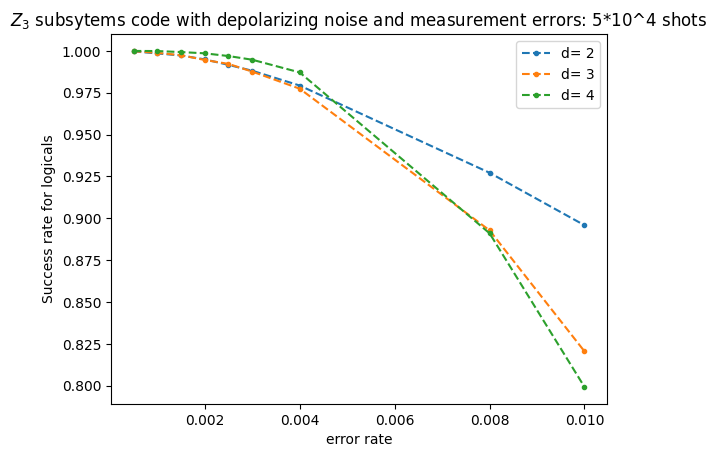

In [58]:
for N in [2,3,4]:
    plt.plot([.0005,.001,.0015, .002,.0025,.003,.004, .008, .01], threshold_list_hlog[N], '.--', label = f'd= {N}')
plt.legend()

plt.title('$Z_3$ subsytems code with depolarizing noise and measurement errors: 5*10^4 shots ')
plt.ylabel('Success rate for logicals')
plt.xlabel('error rate')